In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import math

from keras.models import Sequential
from keras.layers import LSTM, Dense

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
def quartersToHours(data):
    data['date_forecast'] = pd.to_datetime(data['date_forecast'], format='%Y-%m.%d %H:%M:%S')
    data["year"] = data['date_forecast'].dt.year
    data["month"] = data['date_forecast'].dt.month
    data["day"] = data['date_forecast'].dt.day
    data["hour"] = data['date_forecast'].dt.hour


    group = data.groupby([data["year"], data["month"], data["day"], data["hour"]])  
    result = group.mean()
    result = result.reset_index()
    
    return_df = result.drop(['year','month', 'day', 'hour'], axis=1)
    
    return return_df

In [3]:
def join_data_and_labels(train, val, labels):
    
    #Remove hour and minute values
    val = val.assign(date_forecast=val.date_forecast.dt.round('H'))
    train = train.assign(date_forecast=train.date_forecast.dt.round('H'))
    
    #rename columns names to match
    
    train = train.rename(columns={'date_forecast': 'date'})
    val = val.rename(columns={'date_forecast': 'date'})
    labels = labels.rename(columns={'time': 'date'})
    
    joined_train = pd.merge(train, labels, how="inner", on="date")
    joined_val = pd.merge(val, labels, how="inner", on="date")

    
    return joined_train, joined_val

In [4]:
def remove_unused_columns(df):
    df = df.drop(['wind_speed_10m:ms', 'elevation:m', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
                 'wind_speed_w_1000hPa:ms'], axis=1)
    return df

In [5]:
def drop_constanst_columns(train, val, test):
    constanst_columns = []
    # Remove constants
    for key, value in test.std().items():
        if value == 0.0:
            constanst_columns.append(key)

    #for key in constanst_columns:
    #    if val.std()[key] != 0.0 or test.std()[key] != 0.0:
    #        constanst_columns.remove(key)
    print(constanst_columns)
    train.drop(constanst_columns, axis=1,inplace=True)
    val.drop(constanst_columns, axis=1,inplace=True)
    test.drop(constanst_columns, axis=1,inplace=True)

In [6]:
def convert_date_to_sin_and_cos(df):
    day = 24*60*60 #seconds in a day
    year = (365.2425)*day #seconds in a year
    month = year / 12.0

    date_time = pd.to_datetime(df.pop('date'), format='%Y-%m.%d %H:%M:%S')
    timestamp_s = date_time.map(pd.Timestamp.timestamp)

    #df['Month sin'] = np.sin(timestamp_s * (2 * np.pi / month))
    #df['Month cos'] = np.cos(timestamp_s * (2 * np.pi / month))
    
    df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    
    df['Hour sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Hour cos'] = np.cos(timestamp_s * (2 * np.pi / day))

In [7]:
def round_is_day(df):
    df["is_day:idx"] = [round(df["is_day:idx"][i]) for i in range(len(df))]
    df["is_in_shadow:idx"] = [round(df["is_in_shadow:idx"][i]) for i in range(len(df))]
    

In [8]:
def normalize_except_columns(df):
    not_to_be_norm = ["is_day:idx", "Year sin", "Year cos", 'is_in_shadow:idx', 'Hour sin', 'Hour cos']
    cols = df.columns.tolist()
    cols_to_norm = [i for i in cols if i not in not_to_be_norm]
    
    df[cols_to_norm] = df[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))


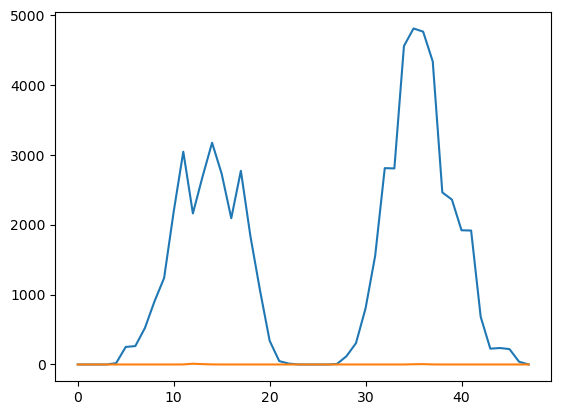

In [9]:
train_a = pd.read_parquet('dataset/A/train_targets.parquet')
train_b = pd.read_parquet('dataset/B/train_targets.parquet')
train_c = pd.read_parquet('dataset/C/train_targets.parquet')

plt.plot(train_a["pv_measurement"][0:24 * 2])
plt.plot(train_b["pv_measurement"][0:24 * 2])
plt.plot(train_c["pv_measurement"][0:24 * 2])

In [10]:
#a_max = train_a["pv_measurement"].max()
#b_max = train_b["pv_measurement"].max()
#c_max = train_c["pv_measurement"].max()

In [11]:
#Load data, sample to hours and drop columns which are not needed
X_train_observed_a = quartersToHours(pd.read_parquet('dataset/A/X_train_observed.parquet')) #Train_x
X_train_observed_b = quartersToHours(pd.read_parquet('dataset/B/X_train_observed.parquet'))
X_train_observed_c = quartersToHours(pd.read_parquet('dataset/C/X_train_observed.parquet'))

X_train_estimated_a = quartersToHours(pd.read_parquet('dataset/A/X_train_estimated.parquet')) # Val_x
X_train_estimated_a = X_train_estimated_a.drop(["date_calc"], axis=1)

X_train_estimated_b = quartersToHours(pd.read_parquet('dataset/B/X_train_estimated.parquet'))
X_train_estimated_b = X_train_estimated_b.drop(["date_calc"], axis=1)

X_train_estimated_c = quartersToHours(pd.read_parquet('dataset/C/X_train_estimated.parquet'))
X_train_estimated_c = X_train_estimated_c.drop(["date_calc"], axis=1)

X_test_estimated_a = quartersToHours(pd.read_parquet('dataset/A/X_test_estimated.parquet'))
X_test_estimated_a = X_test_estimated_a.drop(["date_calc"], axis=1)
test_a = X_test_estimated_a.rename(columns={'date_forecast': 'date'})

X_test_estimated_b = quartersToHours(pd.read_parquet('dataset/B/X_test_estimated.parquet'))
X_test_estimated_b = X_test_estimated_b.drop(["date_calc"], axis=1)
test_b = X_test_estimated_b.rename(columns={'date_forecast': 'date'})

X_test_estimated_c = quartersToHours(pd.read_parquet('dataset/C/X_test_estimated.parquet'))
X_test_estimated_c = X_test_estimated_c.drop(["date_calc"], axis=1)
test_c = X_test_estimated_c.rename(columns={'date_forecast': 'date'})

In [12]:
# Join data and labels into one df
train_data_a, val_data_a = join_data_and_labels(X_train_observed_a, X_train_estimated_a, train_a)
train_data_b, val_data_b = join_data_and_labels(X_train_observed_b, X_train_estimated_b, train_b)
train_data_c, val_data_c = join_data_and_labels(X_train_observed_c, X_train_estimated_c, train_c)

In [13]:
# Remove columns which are not needed
train_data_a = remove_unused_columns(train_data_a)
val_data_a = remove_unused_columns(val_data_a)
test_a = remove_unused_columns(test_a)

train_data_b = remove_unused_columns(train_data_b)
val_data_b = remove_unused_columns(val_data_b)
test_b = remove_unused_columns(test_b)

train_data_c = remove_unused_columns(train_data_c)
val_data_c = remove_unused_columns(val_data_c)
test_c = remove_unused_columns(test_c)

In [14]:
# Convert date into sin and cos components
convert_date_to_sin_and_cos(train_data_a)
convert_date_to_sin_and_cos(val_data_a)
convert_date_to_sin_and_cos(test_a)

convert_date_to_sin_and_cos(train_data_b)
convert_date_to_sin_and_cos(val_data_b)
convert_date_to_sin_and_cos(test_b)

convert_date_to_sin_and_cos(train_data_c)
convert_date_to_sin_and_cos(val_data_c)
convert_date_to_sin_and_cos(test_c)

In [15]:
# Isday should be a binary value
round_is_day(train_data_a)
round_is_day(val_data_a)
round_is_day(test_a)

round_is_day(train_data_b)
round_is_day(val_data_b)
round_is_day(test_b)

round_is_day(train_data_c)
round_is_day(val_data_c)
round_is_day(test_c)

In [16]:
#normalize_except_columns(train_data_a)
#normalize_except_columns(val_data_a)
#normalize_except_columns(test_a)

#normalize_except_columns(train_data_b)
#normalize_except_columns(val_data_b)
#normalize_except_columns(test_b)

#normalize_except_columns(train_data_c)
#normalize_except_columns(val_data_c)
#normalize_except_columns(test_c)

In [17]:
# Fill 0 for NaNs
train_data_a = train_data_a.fillna(0)
val_data_a = val_data_a.fillna(0)
test_a = test_a.fillna(0)

train_data_b = train_data_b.fillna(0)
val_data_b = val_data_b.fillna(0)
test_b = test_b.fillna(0)

train_data_c = train_data_c.fillna(0)
val_data_c = val_data_c.fillna(0)
test_c = test_c.fillna(0)

In [18]:
# Drop columns which are constant
drop_constanst_columns(train_data_a, val_data_a, test_a)
drop_constanst_columns(train_data_b, val_data_b, test_b)
drop_constanst_columns(train_data_c, val_data_c, test_c)

['prob_rime:p', 'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx', 'snow_melt_10min:mm']
['fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'prob_rime:p', 'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx', 'snow_melt_10min:mm']
['snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx', 'snow_melt_10min:mm']


In [19]:
MAX_EPOCHS = 20

def compile_and_fit(model, train_x, train_y, val_x, val_y, patience=3):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=4,
                                                    mode='min',
                                                    restore_best_weights=True)

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.RMSprop(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(x= train_x, y=train_y, epochs=MAX_EPOCHS,
                      validation_data=(val_x, val_y),
                       callbacks=[early_stopping])
    return history

In [20]:
def split_and_batch(df):
    df_labels = df.pop("pv_measurement")
    
    BATCH_SIZE=60

    df_arr = np.array(df, dtype=np.float32)
    df_label_arr = np.array(df_labels, dtype=np.float32)

    # Calculate the number of batches needed
    num_batches = df_arr.shape[0] // BATCH_SIZE

    # Reshape the 2D array into a 3D array with shape (num_batches, BATCH_SIZE, 48)
    if df_arr.shape[0] % BATCH_SIZE == 0:
        # If the data size is a multiple of BATCH_SIZE
        data_3d = df_arr.reshape(num_batches, BATCH_SIZE, -1)
        label_3d = df_label_arr.reshape(num_batches, BATCH_SIZE, -1)

    else:
        # If there's some remaining data that doesn't fit perfectly into batches
        remaining_rows = df_arr.shape[0] % BATCH_SIZE
        data_3d = df_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)
        label_3d = df_label_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)

    return data_3d, label_3d

In [21]:
def batch(df):
    BATCH_SIZE=60

    df_arr = np.array(df, dtype=np.float32)

    # Calculate the number of batches needed
    num_batches = df_arr.shape[0] // BATCH_SIZE

    # Reshape the 2D array into a 3D array with shape (num_batches, BATCH_SIZE, 48)
    if df_arr.shape[0] % BATCH_SIZE == 0:
        # If the data size is a multiple of BATCH_SIZE
        data_3d = df_arr.reshape(num_batches, BATCH_SIZE, -1)

    else:
        # If there's some remaining data that doesn't fit perfectly into batches
        remaining_rows = df_arr.shape[0] % BATCH_SIZE
        data_3d = df_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)

    return data_3d
    

In [22]:
train_a_x, train_a_y = split_and_batch(train_data_a)
val_a_x, val_a_y = split_and_batch(val_data_a)

train_b_x, train_b_y = split_and_batch(train_data_b)
val_b_x, val_b_y = split_and_batch(val_data_b)

train_c_x, train_c_y = split_and_batch(train_data_c)
val_c_x, val_c_y = split_and_batch(val_data_c)

test_a = batch(test_a)
test_b = batch(test_b)
test_c = batch(test_c)

In [23]:
test_a

array([[[ 4.3250003e+00,  1.2867500e+00,  9.1270001e+02, ...,
         -4.7621313e-01,  9.8017141e-02,  9.9518472e-01],
        [ 4.2750001e+00,  1.2860000e+00,  1.4821000e+03, ...,
         -4.7684330e-01,  3.5225004e-01,  9.3590593e-01],
        [ 4.1499996e+00,  1.2837501e+00,  1.7913000e+03, ...,
         -4.7747323e-01,  5.8247769e-01,  8.1284666e-01],
        ...,
        [ 8.3000002e+00,  1.2135000e+00,  0.0000000e+00, ...,
         -6.6420531e-01,  6.3439327e-01, -7.7301043e-01],
        [ 8.1499996e+00,  1.2082500e+00,  0.0000000e+00, ...,
         -6.6474098e-01,  4.1270703e-01, -9.1086382e-01],
        [ 7.5500002e+00,  1.2057500e+00,  2.4631001e+03, ...,
         -6.6527629e-01,  1.6289547e-01, -9.8664331e-01]],

       [[ 6.8249998e+00,  1.2040000e+00,  2.5357000e+03, ...,
         -6.6581130e-01, -9.8017141e-02, -9.9518472e-01],
        [ 6.6500001e+00,  1.2014999e+00,  2.6567000e+03, ...,
         -6.6634589e-01, -3.5225004e-01, -9.3590593e-01],
        [ 7.3000002e+00, 

In [34]:
lstm_model_a = tf.keras.models.Sequential([ 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(60, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotNormal(),
                    bias_initializer='zeros')
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.5)
    ),
    #tf.keras.layers.LSTM(64, return_sequences=True),
    #tf.keras.layers.Dense(units=48),
    #tf.keras.layers.Dense(units=32),

    tf.keras.layers.Dense(units=1, activation="relu")
])

lstm_model_b = tf.keras.models.clone_model(lstm_model_a)
lstm_model_c = tf.keras.models.clone_model(lstm_model_b)

In [35]:
history_a = compile_and_fit(lstm_model_a,train_a_x, train_a_y, val_a_x, val_a_y)
print(f'measure a: {lstm_model_a.evaluate(val_a_x, val_a_y)}')

#[0.006232030689716339, 0.03161332383751869]
#[0.005147780757397413, 0.028607070446014404] -> year and day
#[0.004300971981137991, 0.02555842511355877]
#0.02291605807840824


Epoch 1/20
16/16 [==============================] - 16s 305ms/step - loss: 1879760.1250 - mean_absolute_error: 673.6207 - val_loss: 899488.3750 - val_mean_absolute_error: 339.2903
Epoch 2/20
16/16 [==============================] - 2s 115ms/step - loss: 1871465.7500 - mean_absolute_error: 673.5526 - val_loss: 897479.0625 - val_mean_absolute_error: 340.2340
Epoch 3/20
16/16 [==============================] - 2s 115ms/step - loss: 1868551.7500 - mean_absolute_error: 673.8237 - val_loss: 896350.8125 - val_mean_absolute_error: 340.7025
Epoch 4/20
16/16 [==============================] - 2s 117ms/step - loss: 1866737.3750 - mean_absolute_error: 673.8519 - val_loss: 895203.3125 - val_mean_absolute_error: 341.1884
Epoch 5/20
16/16 [==============================] - 2s 116ms/step - loss: 1865204.6250 - mean_absolute_error: 673.8655 - val_loss: 894097.4375 - val_mean_absolute_error: 341.5620
Epoch 6/20
16/16 [==============================] - 2s 122ms/step - loss: 1863781.1250 - mean_absolute_e

In [36]:
history_b = compile_and_fit(lstm_model_b,train_b_x, train_b_y, val_b_x, val_b_y)
print(f'measure b: {lstm_model_b.evaluate(val_b_x, val_b_y)}')

#[0.007145202253013849, 0.03178989142179489]
#[0.008217844180762768, 0.03327266126871109]
#[0.0067342291586101055, 0.030065299943089485]

Epoch 1/20
16/16 [==============================] - 17s 330ms/step - loss: 49092.8320 - mean_absolute_error: 101.6760 - val_loss: 21231.1738 - val_mean_absolute_error: 53.2723
Epoch 2/20
16/16 [==============================] - 2s 114ms/step - loss: 47999.3164 - mean_absolute_error: 100.8448 - val_loss: 20898.7891 - val_mean_absolute_error: 55.0022
Epoch 3/20
16/16 [==============================] - 2s 113ms/step - loss: 47587.3438 - mean_absolute_error: 100.9696 - val_loss: 20746.3398 - val_mean_absolute_error: 55.7513
Epoch 4/20
16/16 [==============================] - 2s 114ms/step - loss: 47326.4883 - mean_absolute_error: 101.4277 - val_loss: 20645.5449 - val_mean_absolute_error: 56.3808
Epoch 5/20
16/16 [==============================] - 2s 115ms/step - loss: 47126.9922 - mean_absolute_error: 101.1145 - val_loss: 20569.9668 - val_mean_absolute_error: 56.6301
Epoch 6/20
16/16 [==============================] - 2s 115ms/step - loss: 46936.6680 - mean_absolute_error: 100.9819 - val_l

In [37]:
history_c = compile_and_fit(lstm_model_c,train_c_x, train_c_y, val_c_x, val_c_y)
print(f'measure c: {lstm_model_c.evaluate(val_c_x, val_c_y)}')

#[0.004318469204008579, 0.02518327347934246]
#[0.004314047750085592, 0.025382312014698982]
#[0.003403852926567197, 0.02470281533896923]

Epoch 1/20
16/16 [==============================] - 17s 319ms/step - loss: 28218.5527 - mean_absolute_error: 65.5302 - val_loss: 12474.6553 - val_mean_absolute_error: 42.8512
Epoch 2/20
16/16 [==============================] - 2s 118ms/step - loss: 27598.2129 - mean_absolute_error: 66.1521 - val_loss: 12327.4033 - val_mean_absolute_error: 43.7761
Epoch 3/20
16/16 [==============================] - 2s 117ms/step - loss: 27357.3965 - mean_absolute_error: 67.0282 - val_loss: 12244.5791 - val_mean_absolute_error: 44.3402
Epoch 4/20
16/16 [==============================] - 2s 118ms/step - loss: 27215.1211 - mean_absolute_error: 67.1257 - val_loss: 12194.1406 - val_mean_absolute_error: 44.5910
Epoch 5/20
16/16 [==============================] - 2s 119ms/step - loss: 27093.5684 - mean_absolute_error: 67.3000 - val_loss: 12108.0654 - val_mean_absolute_error: 45.2776
Epoch 6/20
16/16 [==============================] - 2s 120ms/step - loss: 26977.1211 - mean_absolute_error: 67.4939 - val_loss: 1

In [38]:
#lstm_model_a.get_weight_paths()

In [39]:
pred_a = lstm_model_a.predict(test_a)
pred_b = lstm_model_b.predict(test_b)
pred_c = lstm_model_c.predict(test_c)

pred_a_val = lstm_model_a.predict(val_a_x)
pred_b_val = lstm_model_b.predict(val_b_x)
pred_c_val = lstm_model_c.predict(val_c_x)

2/2 [==============================] - 0s 49ms/step


In [40]:
pred_a = pred_a.flatten() #* a_max
pred_b = pred_b.flatten() #* b_max
pred_c = pred_c.flatten() #* c_max

pred_a_val = pred_a_val.flatten() #* a_max
pred_b_val = pred_b_val.flatten() #* b_max
pred_c_val = pred_c_val.flatten() #* c_max

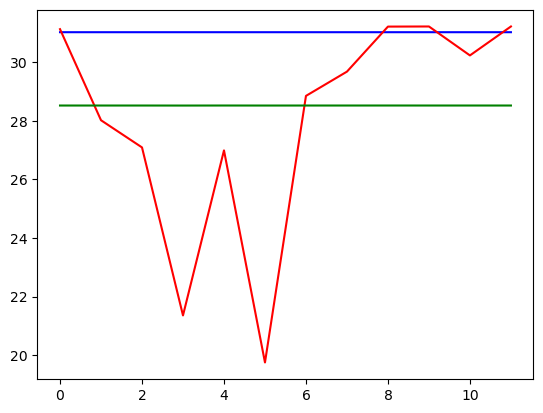

In [41]:
plt.plot(pred_a[0:24*7], color="blue")
plt.plot(pred_b[0:24*7], color="red")
plt.plot(pred_c[0:24*7], color="green")

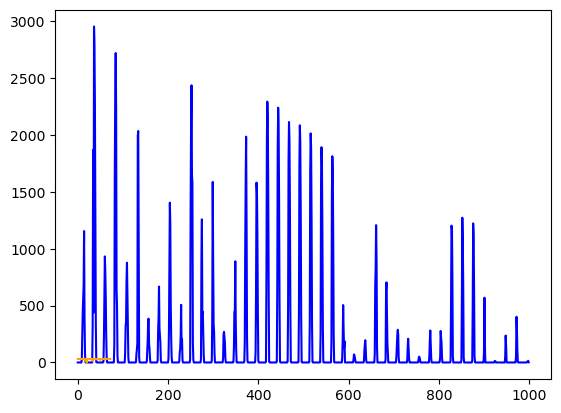

In [42]:

plt.plot(val_a_y.flatten()[:1000], color="blue")
plt.plot(pred_a_val[:1000], color="orange")


In [243]:
test = pd.read_csv('test.csv')

test

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0,A
1,1,2023-05-01 01:00:00,0,A
2,2,2023-05-01 02:00:00,0,A
3,3,2023-05-01 03:00:00,0,A
4,4,2023-05-01 04:00:00,0,A
...,...,...,...,...
2155,2155,2023-07-03 19:00:00,0,C
2156,2156,2023-07-03 20:00:00,0,C
2157,2157,2023-07-03 21:00:00,0,C
2158,2158,2023-07-03 22:00:00,0,C


In [244]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,id,prediction
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2155,2155,0
2156,2156,0
2157,2157,0
2158,2158,0


In [245]:
submit = np.concatenate((np.concatenate((pred_a, pred_b)),pred_c))

In [246]:
from datetime import datetime

now = datetime.now() # current date and time

# Example, let the predictions be random values
test['prediction'] = submit
sample_submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv("bi_vol2.csv", index=False)